In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
%matplotlib inline
import tqdm

In [82]:
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection

In [84]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor,LogisticRegression,LassoCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [6]:
#func for writing prediction into csv file
def write_sumb(name,prediction):
    pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':prediction}).to_csv(name,index=False)

In [7]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [8]:
y = train.SalePrice
X = train.drop('SalePrice',axis=1)

In [9]:
# preprocessing of columns(normalization for numeric and onehotencoding for categoric)
categorical_features = np.where(X.dtypes=='object')[0]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [10]:
X = preprocessor.fit_transform(X)
test = preprocessor.transform(test)
X = X.toarray()
test = test.toarray()

In [89]:
# Before grid search

In [11]:
results = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [17]:
def evaluate_score(model,X=X,y=y):
    ''' 
    Function counts cross-validation score, holdout (on test set) score, time (overall train + prediction) of model
    Crossval score is rmse, cv = 3
    
    '''
    time_before = time.time() 
    model_instance = model
    cvs = np.int(np.sqrt(np.abs(cross_val_score(model,X,y,cv=5,
                                                scoring='neg_mean_squared_error').mean())))
    if cvs>1e11:
        cvs = np.inf

    time_after = time.time()
    result = pd.DataFrame({'name':model.__class__.__name__,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    #print(result)
    return result

In [18]:
regressors = [LinearRegression(),Ridge(random_state = 5),
              Lasso(random_state=5),DecisionTreeRegressor(random_state=5),
              SGDRegressor(random_state=5),GradientBoostingRegressor(random_state=5),
              RandomForestRegressor(random_state=5),KNeighborsRegressor()]

In [19]:
for regressor in regressors:
    results = results.append(evaluate_score(regressor))

LinearRegression()
Ridge(random_state=5)
Lasso(random_state=5)


/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10570682462.487244, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(
/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5013119352.130615, tolerance: 724930391.3116124
  model = cd_fast.enet_coordinate_descent(


DecisionTreeRegressor(random_state=5)
SGDRegressor(random_state=5)
GradientBoostingRegressor(random_state=5)
RandomForestRegressor(random_state=5)
KNeighborsRegressor()


In [20]:
results.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,27197.0,3.309788
0,RandomForestRegressor,30296.0,9.351306
0,Ridge,32709.0,0.029294
0,SGDRegressor,32729.0,0.118549
0,Lasso,34294.0,0.849146
0,KNeighborsRegressor,38502.0,0.734101
0,DecisionTreeRegressor,44027.0,0.207611
0,LinearRegression,inf,0.134527


In [72]:
# after grid search

In [62]:
results_grid = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [63]:
def evaluate_score_grid(model,params,X=X,y=y):
    ''' Gridsearch for different models'''
    name = model.__class__.__name__
    time_before = time.time() 
    model_instance = GridSearchCV(model,params,cv=5,scoring='neg_mean_squared_error').fit(X,y)
    cvs = np.int(np.sqrt(np.abs(model_instance.best_score_)))
    print(model,model_instance.best_params_)
    if cvs>1e10:
        cvs=np.inf
    time_after = time.time()
    result = pd.DataFrame({'name':name,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    #print(result)
    return result

In [64]:
regressors = [LinearRegression(),Ridge(),
              Lasso(),DecisionTreeRegressor(),
              SGDRegressor(),GradientBoostingRegressor(),
              RandomForestRegressor(),KNeighborsRegressor()]

In [66]:
linear_params = {
    'fit_intercept':[True,False]
}
ridge_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
lasso_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
tree_params = {
    'max_depth':[3,5,8,10,15],
    'min_samples_leaf':[1,2,5,10],
    'random_state':[5]   
}
SGDRegressor_params = {
    'penalty':['l2','l1','elasticnet'],
    'max_iter':[1000,2000,5000],
    'learning_rate':['invscaling','optimal'],
    'random_state':[5]
}
GradientBoostingRegressor_params = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[500,1000,2000],
    'random_state':[5]
}
RandomForestRegressor_params = {
    'n_estimators':[500,1000,2000],
    'max_depth':[5,10,None],
    'random_state':[5]
}
KNeighborsRegressor_params = {
    'n_neighbors':[3,5,7,9],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
params = [linear_params,ridge_params,lasso_params,tree_params,
          SGDRegressor_params,GradientBoostingRegressor_params,
          RandomForestRegressor_params,KNeighborsRegressor_params]

In [67]:
%%time
for i,regressor in enumerate(regressors):
    results_grid = results_grid.append(evaluate_score_grid(regressor,params=params[i]))

LinearRegression() {'fit_intercept': True}
Ridge() {'alpha': 10, 'max_iter': 1000, 'random_state': 5}


/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10570682462.487244, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(
/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5013119352.130615, tolerance: 724930391.3116124
  model = cd_fast.enet_coordinate_descent(
/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5739126118.564514, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(


Lasso() {'alpha': 200, 'max_iter': 1000, 'random_state': 5}
DecisionTreeRegressor() {'max_depth': 15, 'min_samples_leaf': 10, 'random_state': 5}
SGDRegressor() {'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 5}
GradientBoostingRegressor() {'learning_rate': 0.01, 'n_estimators': 2000, 'random_state': 5}
RandomForestRegressor() {'max_depth': None, 'n_estimators': 2000, 'random_state': 5}
KNeighborsRegressor() {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}
CPU times: user 20min 47s, sys: 18.1 s, total: 21min 6s
Wall time: 20min 4s


In [68]:
results_grid.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,25751.0,376.955190
0,RandomForestRegressor,29973.0,793.839336
0,Lasso,31184.0,6.699830
0,Ridge,31939.0,0.522141
0,SGDRegressor,32729.0,13.204332
0,KNeighborsRegressor,37107.0,10.920441
0,DecisionTreeRegressor,38377.0,1.735675
0,LinearRegression,inf,0.276734


In [71]:
regressors_opt = [LinearRegression(),Ridge(alpha=10,max_iter=1000,random_state=5),
                  Lasso(alpha=200,max_iter=1000,random_state=5),
                  DecisionTreeRegressor(max_depth=15,min_samples_leaf=10,random_state=5),
                  SGDRegressor(max_iter=1000,penalty='l2',learning_rate='invscaling',random_state=5),
                  GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000,random_state=5),
                  RandomForestRegressor(max_depth=None,n_estimators=2000,random_state=5),
                  KNeighborsRegressor(algorithm='ball_tree',n_neighbors=9,weights='distance')]

In [ ]:
# After PCA(0.95 explained variance) preparaion

In [73]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)
test_pca = pca.transform(test)

In [74]:
results_pca = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [77]:
for regressor in regressors_opt:
    results_pca = results_pca.append(evaluate_score(regressor,X_pca,y))

In [78]:
results_pca.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,27147,175.260688
0,RandomForestRegressor,30180,331.036387
0,Lasso,33820,0.013977
0,Ridge,33876,0.015198
0,LinearRegression,34003,0.044546
0,SGDRegressor,35000,0.028135
0,DecisionTreeRegressor,36488,0.227472
0,KNeighborsRegressor,36860,0.137128


In [483]:
# Feature selection 
# Selection from LassoCV model

In [79]:
results_feat_select = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [85]:
selector = feature_selection.SelectFromModel(LassoCV(cv=5,random_state=5)).fit(X,y)
X_selected = selector.transform(X)
test_selected = selector.transform(test)

In [89]:
X.shape[1] - X_selected.shape[1] # amount of columns were dropped (overall 270)

182

In [90]:
for regressor in regressors_opt:
    results_feat_select = results_feat_select.append(evaluate_score(regressor,X_selected,y))

In [91]:
results_feat_select.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,25248,36.009543
0,RandomForestRegressor,29685,109.843615
0,Ridge,30567,0.015499
0,Lasso,30969,0.038176
0,LinearRegression,31621,0.043807
0,SGDRegressor,32420,0.052163
0,KNeighborsRegressor,36971,0.164373
0,DecisionTreeRegressor,37740,0.062827


In [117]:
res = pd.merge(results, results_grid, how='left', left_on='name', right_on='name', suffixes=('', '_grid'))
res = pd.merge(res, results_pca, how='left', left_on='name', right_on='name', suffixes=('', '_pca'))
res = res = pd.merge(res, results_feat_select, how='left', left_on='name', right_on='name', suffixes=('', '_sel'))

In [160]:
res

,name,cross_val_score,time,cross_val_score_grid,time_grid,cross_val_score_pca,time_pca,cross_val_score_sel,time_sel
0,LinearRegression,inf,0.134527,inf,0.276734,34003,0.044546,31621,0.043807
1,Ridge,32709.0,0.029294,31939.0,0.522141,33876,0.015198,30567,0.015499
2,Lasso,34294.0,0.849146,31184.0,6.699830,33820,0.013977,30969,0.038176
3,DecisionTreeRegressor,44027.0,0.207611,38377.0,1.735675,36488,0.227472,37740,0.062827
4,SGDRegressor,32729.0,0.118549,32729.0,13.204332,35000,0.028135,32420,0.052163
5,GradientBoostingRegressor,27197.0,3.309788,25751.0,376.955190,27147,175.260688,25248,36.009543
6,RandomForestRegressor,30296.0,9.351306,29973.0,793.839336,30180,331.036387,29685,109.843615
7,KNeighborsRegressor,38502.0,0.734101,37107.0,10.920441,36860,0.137128,36971,0.164373


In [156]:
process = ['base','grid','pca','selection']
labels = res.loc[:,'name']

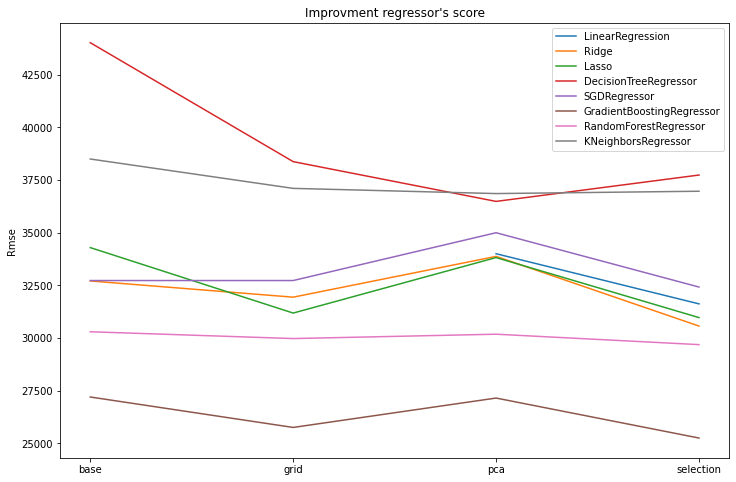

In [159]:
plt.figure(figsize=(12,8))
for i in range(res.shape[0]):
    res.loc[i,score_names].plot()
plt.legend(labels)
plt.ylabel('Rmse')
plt.title("Improvment regressor's score")
plt.xticks(ticks = np.arange(4),labels=process);